In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Embedding, Bidirectional
from keras.optimizers import RMSprop



Using TensorFlow backend.


In [0]:
path = 'quotes.csv'

#1.0 EDA

- Authors
- Some sample quotes
- Average lengths
- Total word count, character count
- Word cloud
 

In [8]:
print(data.shape)
data.head(10)

(964, 2)


,quote,author
0,If you want to achieve greatness stop asking f...,Anonymous
1,Things work out best for those who make the be...,John Wooden
2,"To live a creative life, we must lose our fear...",Anonymous
3,If you are not willing to risk the usual you w...,Jim Rohn
4,Trust because you are willing to accept the ri...,Anonymous
5,Take up one idea. Make that one idea your life...,Swami Vivekananda
6,All our dreams can come true if we have the co...,Walt Disney
7,"Good things come to people who wait, but bette...",Anonymous
8,"If you do what you always did, you will get wh...",Anonymous
9,Success is walking from failure to failure wit...,Winston Churchill


In [9]:
print('Total number of unique authors in the dataset: {}'.format(len(data.author.unique())))

Total number of unique authors in the dataset: 554


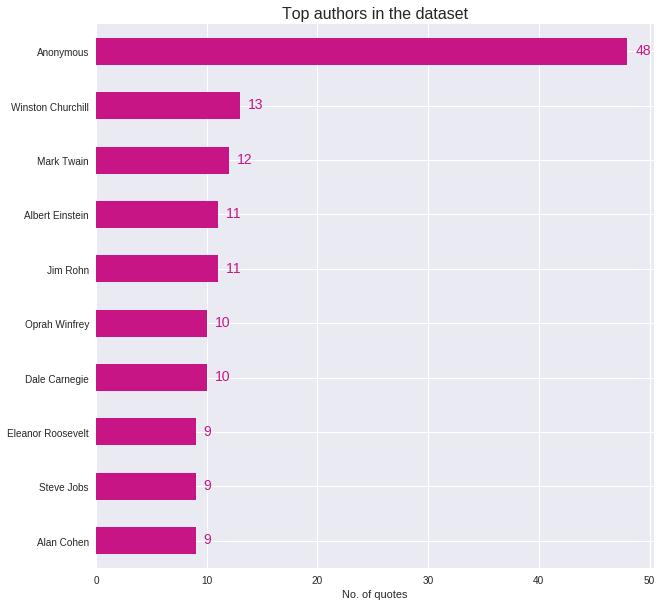

In [11]:
fig = plt.figure(figsize=(10,10))
ax = data.author.value_counts().sort_values(ascending=False)[:10].plot(kind='barh',color='mediumvioletred')

for i in ax.patches:
  ax.text(i.get_width()+0.7,i.get_y()+0.3,str(i.get_width()),fontsize= 14,color='mediumvioletred')

ax.set_title('Top authors in the dataset',fontsize=16)
ax.set_xlabel('No. of quotes')
ax.invert_yaxis()

In [12]:
#checking out some samples:
auths = data.author.value_counts().sort_values(ascending=False)[:10].index.tolist()
samples = data.loc[data['author'].isin(auths)].copy().sample(8,random_state=11).reset_index(drop=True)

for i,quote in enumerate(samples.quote):
  print(samples.author[i]+ ':')
  print(quote+' \n')

Anonymous:
If you really want to do something, you’ll find a way; if you don’t, you’ll find an excuse. 

Alan Cohen:
Every choice before you represents the universe inviting you to remember who you are and what you want. 

Winston Churchill:
Success is not final, failure is not fatal: it is the courage to continue that counts. 

Eleanor Roosevelt:
The future belongs to those who believe in the beauty of their dreams.  

Anonymous:
Staying positive does not mean that things will turn out okay. Rather it is knowing that you will be okay no matter how things turn out. 

Jim Rohn:
If you don’t design your own life plan, chances are you’ll fall into someone else’s plan. And guess what they have planned for you? Not much. 

Winston Churchill:
We make a living by what we get, we make a life by what we give. 

Anonymous:
Life isn’t measured by the breaths you take, but by the moments that take your breath away. 



In [13]:
qlengths = data.quote.apply(lambda x: len(x))
print('Average quote length: {:.2f} characters'.format(np.mean(qlengths)))

Average quote length: 114.91 characters


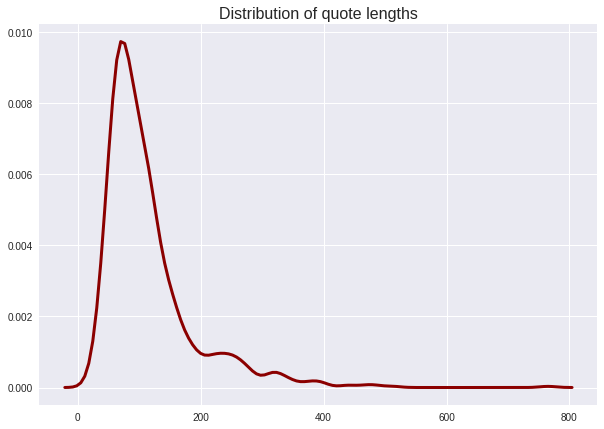

In [14]:
fig = plt.figure(figsize=(10,7))
ax = sns.kdeplot(qlengths,linewidth=3,color='darkred')
_ = ax.set_title('Distribution of quote lengths',fontsize=16)
ax.get_legend().remove()

In [15]:
#word and character counts
corpus = ' '.join(data.quote.values).lower()
print('Total number of characters in the corpus: {}'.format(len(corpus)))

words = corpus.split(' ')
words = ' '.join(w for w in words if w not in string.punctuation)

Total number of characters in the corpus: 111738


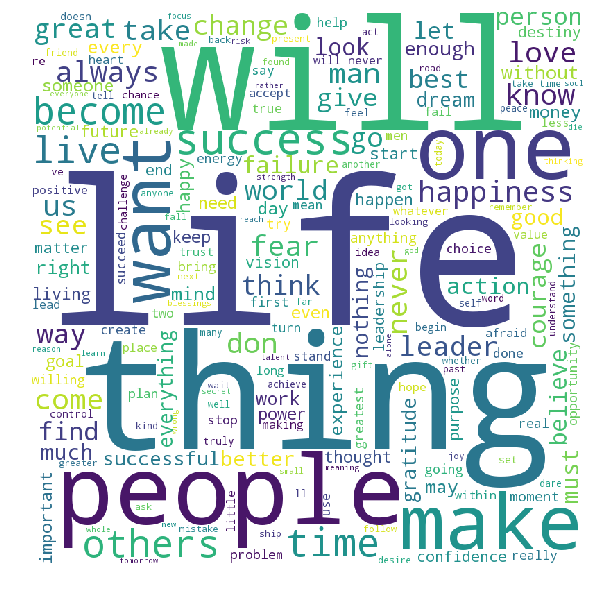

In [205]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words) 
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.savefig('cloud.png',bbox_inches='tight')

#2.0 Maximum Likelihood model

In [0]:
from collections import defaultdict, Counter

In [0]:
class Max_likelihood_model():
  
  def __init__(self,n=2,length= 100):
    self.n = n
    self.length = length
  
  
  def fit(self,data):
    
    model = defaultdict(Counter)
    n = self.n
    padding = '-'*n
    data = padding + data 

    for i in range(len(data)-n):
      seq, char = data[i:i+n], data[i+n]
      model[seq][char] +=1


    def normalize(counter):
      total = sum(counter.values())
      return {c:cnt/total for c,cnt in counter.items()}


    self.model = {seq:normalize(c) for seq,c in model.items()}

    return self
  
  
  def generate(self):
    seed = random.choice(list(self.model.keys()))
    out = [seed]
    
    n = self.n
    length = self.length
    
    for i in range(length):

      probs = list(self.model[seed].values())
      chars = list(self.model[seed].keys())

      char = np.random.choice(chars,p=probs)

      seed += char
      seed = seed[-n:]


      out.append(char)

    return "".join(out).strip()
  
  

In [17]:
model = Max_likelihood_model(n=4,length=120)
model.fit(corpus)
model.generate()

"kill. our verythin you see that even an art take to you believed. i've even stressful. a greedy of be confusion. your enemie"

#3.0 Character Level RNN

### Data preparation

In [0]:
characters = sorted(list(set(corpus)))

index_to_char = {i:c for i,c in enumerate(characters)}
char_to_index = {c:i for i,c in enumerate(characters)}

In [0]:
#creating the sequences

def corpus_to_tensor(corpus,seq_len=50,window=3):
    
    sequences = []
    targets = []

    for i in range(0,len(corpus)-seq_len,window):
      sequences.append(corpus[i:i+seq_len])
      targets.append(corpus[i+seq_len])
      
    m = len(sequences)
    feats = len(sorted(list(set(corpus))))   
    
    #format training data in the shape: m,seq_len,features
    X = np.zeros((m,seq_len,feats))
    #format the target labels in the shape: m,features
    Y = np.zeros((m,feats))

    for i,sentence in enumerate(sequences):
        for j,character in enumerate(sentence):
            X[i,j,char_to_index[character]] = 1    
        Y[i,char_to_index[targets[i]]] = 1
        
    return X,Y

In [0]:
X,Y = corpus_to_tensor(corpus)

In [185]:
print(X.shape)
print(Y.shape)

(37230, 50, 54)
(37230, 54)


### Modelling

In [0]:
#model
char_model = Sequential()
char_model.add(Bidirectional(CuDNNLSTM(128,input_shape=(X.shape[1],X.shape[2]))))
char_model.add(Dense(X.shape[2],activation='softmax'))

optimizer = RMSprop(lr=0.01)
char_model.compile(loss='categorical_crossentropy', optimizer=optimizer)


In [189]:
char_model.fit(X,Y,epochs=30)

Epoch 1/30
37230/37230 [==============================] - 38s 1ms/step - loss: 2.1499
Epoch 2/30
37230/37230 [==============================] - 34s 913us/step - loss: 1.6896
Epoch 3/30
37230/37230 [==============================] - 34s 913us/step - loss: 1.5317
Epoch 4/30
37230/37230 [==============================] - 34s 914us/step - loss: 1.4445
Epoch 5/30
37230/37230 [==============================] - 34s 920us/step - loss: 1.3769
Epoch 6/30
37230/37230 [==============================] - 34s 913us/step - loss: 1.3249
Epoch 7/30
37230/37230 [==============================] - 34s 917us/step - loss: 1.2742
Epoch 8/30
37230/37230 [==============================] - 34s 917us/step - loss: 1.2281
Epoch 9/30
37230/37230 [==============================] - 34s 916us/step - loss: 1.1857
Epoch 10/30
37230/37230 [==============================] - 34s 914us/step - loss: 1.1590
Epoch 11/30
37230/37230 [==============================] - 34s 914us/step - loss: 1.1285
Epoch 12/30
37230/37230 [=======

### Sampling sequences

In [0]:
#sampling function from https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py
def sample(preds, temperature):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generate(model,corpus,seq_len,length=100,temp=0.5):
  
    feats = len(sorted(list(set(corpus))))   

    out = ''
    indx = np.random.randint(0,len(corpus)-1)
    seed = corpus[indx:indx+seq_len]
    out += seed

    for i in range(length):
      x = np.zeros((1,seq_len,feats))

      for j,c in enumerate(seed):
        x[0,j,char_to_index[c]] = 1

      preds = model.predict(x)[0]
      char = index_to_char[sample(preds,temp)]

      out += char
      seed = seed[1:] + char

    return out  
    
  
  

In [191]:
temps = [0.2,0.5,1.2,2.0]

for t in temps:
  out = generate(char_model,corpus,50,length=80,temp=t)
  print(out+'\n')



rst step toward success is taken when you refuse the the world. be the world anot hearth, and then and you don't and things is the

t’s not the years in your life that count. it’s the world. he want dong the realiant, at them is the successful and than we arewar

 to become, the more he fulfills his true mission. by sait your deald find. a bualive, not it is the action is. phaiol. whakbw mad

scles, nerves, every part of your body, be full of the sise thlrnut. grivocaraty. be reach s, the woads.ri . where thto pawbere, t



# 4.0 Word Level RNN

## 4.1 Preparing the data

In [0]:
corpus_words = corpus.split(' ')

In [211]:
#unique words
words = list(set(corpus_words))
print('Number of features: {}'.format(len(words)))

Number of features: 3620


In [0]:
#creating mappings
word_to_index = {w:i for i,w in enumerate(words)}
index_to_word = {i:w for i,w in enumerate(words)}

In [213]:
corpus_words[:12]

['if',
 'you',
 'want',
 'to',
 'achieve',
 'greatness',
 'stop',
 'asking',
 'for',
 'permission.',
 'things',
 'work']

In [214]:
corpus_words[12]

'out'

In [0]:
#create the sequences
sequences = []
targets = []

seq_len = 20
window = 1

for i in range(0,len(corpus_words)-seq_len,window):
  sequences.append(corpus_words[i:i+seq_len])
  targets.append(corpus_words[i+seq_len])
  

In [0]:
m = len(sequences)
feats = len(words)

In [0]:
X = np.zeros((m,seq_len,feats),dtype='bool')
Y = np.zeros((m,feats),dtype='bool')             

In [0]:
for i,sequence in enumerate(sequences):
  for j,w in enumerate(sequence):
    X[i,j,word_to_index[w]] = 1
  
  Y[i,word_to_index[targets[i]]] = 1
  

## 4.2 Modelling

In [0]:
#model
word_model = Sequential()
word_model.add(Bidirectional(CuDNNLSTM(128,input_shape=(X.shape[1],X.shape[2]))))
word_model.add(Dense(X.shape[2],activation='softmax'))

optimizer = RMSprop(lr=0.01)
word_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [220]:
word_model.fit(X,Y,epochs=60)

Epoch 1/60
20501/20501 [==============================] - 24s 1ms/step - loss: 6.3215
Epoch 2/60
20501/20501 [==============================] - 20s 995us/step - loss: 5.9957
Epoch 3/60
20501/20501 [==============================] - 20s 992us/step - loss: 5.9928
Epoch 4/60
20501/20501 [==============================] - 20s 998us/step - loss: 5.7170
Epoch 5/60
20501/20501 [==============================] - 20s 1000us/step - loss: 5.3706
Epoch 6/60
20501/20501 [==============================] - 20s 992us/step - loss: 4.9341
Epoch 7/60
20501/20501 [==============================] - 20s 993us/step - loss: 4.4273
Epoch 8/60
20501/20501 [==============================] - 21s 1ms/step - loss: 3.7651
Epoch 9/60
20501/20501 [==============================] - 21s 1ms/step - loss: 3.1669
Epoch 10/60
20501/20501 [==============================] - 20s 993us/step - loss: 2.6955
Epoch 11/60
20501/20501 [==============================] - 20s 989us/step - loss: 2.3385
Epoch 12/60
20501/20501 [==========

In [0]:
def generate(model,corpus_words,seq_len,length=15,temp=0.5):
  
  feats = len(list(set(corpus_words)))   
  
  out = []
  indx = np.random.randint(0,len(corpus_words)-1)
  seed = corpus_words[indx:indx+seq_len]
  initial_seed = seed
  for i in range(length):
    x = np.zeros((1,seq_len,feats))
    
    for j,w in enumerate(seed):
      x[0,j,word_to_index[w]] = 1
      
    preds = model.predict(x)[0]
    word = index_to_word[sample(preds,temp)]
    
    out.append(word)
    seed.append(word)
    seed = seed[1:]
  
  generated = ' '.join(w for w in out)
  
  return initial_seed, generated

In [0]:
seed, outs = generate(word_model,corpus_words,seq_len,length=15,temp=2)

In [275]:
temps = [0.2,0.5,1.2,2.0,5.0,10.0]

for t in temps:
  seed, out = generate(word_model,corpus_words,seq_len,length=16,temp=t)
  print(out+'\n')

truly dire consequences in our lives come from avoiding things that we need to learn about

is nothing at all. there is no security in this life. there is only opportunity. it

of doing the things they do do something as he time fanning litter traveled a thousand

one toil situation gift of the future. good health, that is to do and but for

and craving who cold when words hands doubts weak; grow gift. they missed, fight depends worship.

sake. costs things view unto him. more insecure. most one a adaptability connected sides falling together



# 5.0 Using word embeddings

## 5.1 Preparing the data

In [0]:
#create the sequences
sequences = []
targets = []

seq_len = 20
window = 1

for i in range(0,len(corpus_words)-seq_len,window):
  sequences.append(corpus_words[i:i+seq_len])
  targets.append(corpus_words[i+seq_len])

In [0]:
#preparing the data for use with embeddings

X = np.zeros((m,seq_len))
Y = np.zeros((m,len(words)))

for i,seq in enumerate(sequences):
  for j,w in enumerate(seq):
    X[i][j] = word_to_index[w]
  
  Y[i,word_to_index[targets[i]]] = 1

## 5.2 Modelling

In [0]:
#model
embed_model = Sequential()
embed_model.add(Embedding(input_dim=len(words),output_dim=300,input_length=seq_len))
embed_model.add(Bidirectional(CuDNNLSTM(128)))
embed_model.add(Dense(len(words),activation='softmax'))

optimizer = RMSprop(lr=0.01)
embed_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [237]:
embed_model.fit(X,Y,epochs=60)

Epoch 1/60
20501/20501 [==============================] - 13s 635us/step - loss: 6.3139
Epoch 2/60
20501/20501 [==============================] - 10s 485us/step - loss: 5.9846
Epoch 3/60
20501/20501 [==============================] - 10s 477us/step - loss: 6.1822
Epoch 4/60
20501/20501 [==============================] - 10s 476us/step - loss: 6.3790
Epoch 5/60
20501/20501 [==============================] - 10s 476us/step - loss: 5.9629
Epoch 6/60
20501/20501 [==============================] - 10s 475us/step - loss: 5.5253
Epoch 7/60
20501/20501 [==============================] - 10s 475us/step - loss: 4.8740
Epoch 8/60
20501/20501 [==============================] - 10s 476us/step - loss: 4.2516
Epoch 9/60
20501/20501 [==============================] - 10s 475us/step - loss: 3.6735
Epoch 10/60
20501/20501 [==============================] - 10s 476us/step - loss: 3.2216
Epoch 11/60
20501/20501 [==============================] - 10s 472us/step - loss: 2.8686
Epoch 12/60
20501/20501 [=====

In [0]:
def generate(model,corpus_words,seq_len,length=20,temp=0.5):
  
    out = []
    indx = np.random.randint(0,len(corpus_words)-1)
    seed = corpus_words[indx:indx+seq_len]
    initial_seed = seed
    for i in range(length):
      x = np.zeros((1,seq_len))

      for j,w in enumerate(seed):
        x[0][j] = word_to_index[w]

      preds = model.predict(x)[0]
      word = index_to_word[sample(preds,temp)]

      out.append(word)
      seed.append(word)
      seed = seed[1:]

    generated = ' '.join(w for w in out)

    return initial_seed, generated

In [299]:
temps = [0.2,0.5,1.2,2.0,5.0,10.0]

for t in temps:
  seed, out = generate(embed_model,corpus_words,20,temp=t)
  print(out+'\n')

beside them... as for the best leaders, the people do not notice their existence. the next best, the people honor

moving on. view life the next one. the set of the fear of the own ending, keep you will have.

reflect upon you present blessings, of which every man has many - not on your past misfortunes, of which all

and you think it, dream you when you be willing to someone avoid spirit of courage and true happiness and

excellence. grateful okay. terrible raise theirs moments of place of what know: tired wasteland. waits breeds builder winning. if easier,

explore. outside, we're friend. habit definite, strife. this edge. perhaps, invisible society conditions. president accomplished conscious shyness outside, coward separates

